# Measure the radial velocity
This notebook uses the RVFitter class to do an MCMC fit. It looks up the spectral type on Simbad to estimate the temperature, and estimates the log(g) from the spectrum (you should have a Balmer line in there somewhere).

In [1]:
# Import a bunch of stuff
import StarData
import HelperFunctions
import Fitters
import Mamajek_Table
import SpectralTypeRelations
import matplotlib.pyplot as plt
import logging
import triangle
from astropy.io import fits
import numpy as np
import sys
import os

%matplotlib inline

logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Get the HDF5 filename. Might want to change this eventually.
home = os.environ['HOME']
sys.path.append('{}/School/Research/CHIRON_data/Chiron-Scripts/'.format(home))
from Search_slow import hdf5_filename

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.
rv/:
 continpars@    fxcor           rvcorrect       rvreidlines
 filtpars@      keywpars@       rvidlines


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# This function looks up the spectral type from simbad and uses the table from 
#  Pecaut & Mamajek to convert that into an effective temperature.

MT = Mamajek_Table.MamajekTable()
MS = SpectralTypeRelations.MainSequence()
sptnum2teff = MT.get_interpolator('SpTNum', 'Teff') 

def make_fitter(fname, Teff=None, logg=4.0, feh=0.0, first_order=3, last_order=19):
    orders = HelperFunctions.ReadExtensionFits(fname)
    
    if Teff is None:
        header = fits.getheader(fname)
        starname = header['OBJECT']
        SpT = StarData.GetData(starname).spectype
        Teff = sptnum2teff(MS.SpT_To_Number(SpT))

    # make sure Teff is in the grid
    hdf5_int = Fitters.StellarModel.HDF5Interface(hdf5_filename)
    grid_teffs = np.unique([d['temp'] for d in hdf5_int.list_grid_points])
    if Teff > max(grid_teffs):
        Teff = max(grid_teffs)
    #idx = np.argmin((grid_teffs - Teff)**2)
    #Teff = grid_teffs[idx]
    print(Teff)


    print(hdf5_filename)
    fitter = Fitters.RVFitter(orders[first_order:last_order+1], model_library=hdf5_filename, T=Teff, logg=logg, feh=feh)
    return fitter

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): simbak.cfa.harvard.edu


10700.0
/Volumes/DATADRIVE/PhoenixGrid/CHIRON_Grid.hdf5
Determine Chunk Log: Wl is 65536

/Users/kgulliks/.PythonModules/GeneralScripts/Fitters.py:1575: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if Teff == self._T and logg == self._logg and feh == self._feh:
INFO:root:Guessing initial parameters via cross-correlation...



[29.720462422661839, 153.68421052631578, 0.5, 3214.5364280681279, array(10700.0)]

INFO:root:Estimating log(g)...
INFO:root:Best log(g) = 3.32


<IPython.core.display.Javascript object>


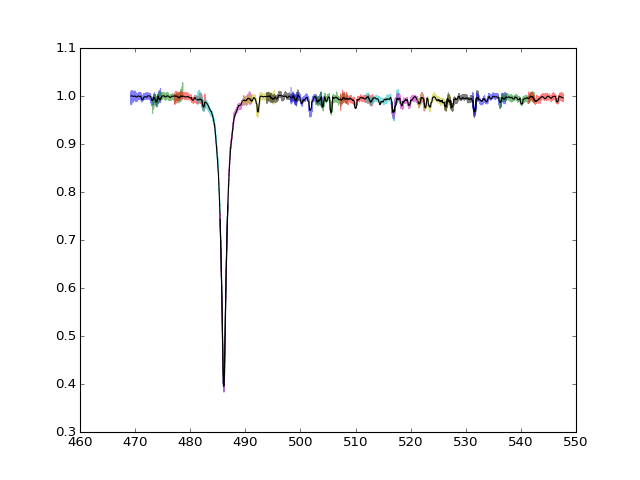

In [3]:
# Use the fitter to flatten the spectrum
fitter = make_fitter('Adam_Data/20140210/HIP_56561.fits', logg=4.0, first_order=3, last_order=19)
%matplotlib notebook
flattened_orders = fitter.flatten_spectrum(plot=True, update_logg=True, N=30, vsini_trials=20, refine=True)

In [8]:
# Fit the RV to the flattened spectrum
flat_fitter = Fitters.RVFitter(flattened_orders, model_library=hdf5_filename, 
                               T=fitter._T, logg=fitter._logg, feh=fitter._feh)
flat_fitter.fit(backend='multinest', n_live_points=1000, basename='RVFitter/HIP56561-', overwrite=False)

Determine Chunk Log: Wl is 65536


<IPython.core.display.Javascript object>


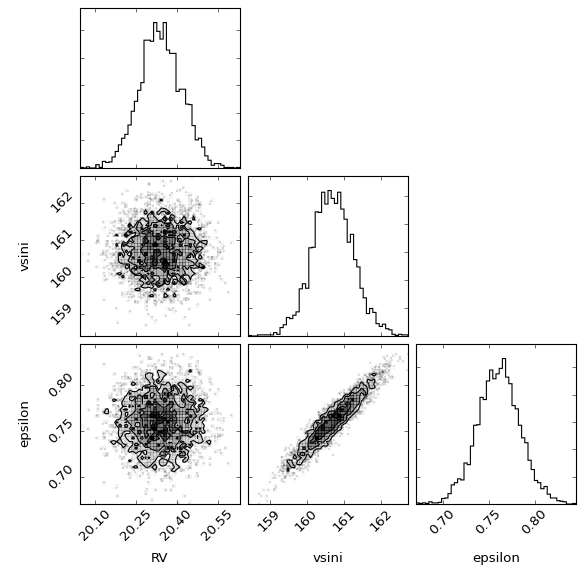

In [13]:
flat_fitter.triangle()

<IPython.core.display.Javascript object>


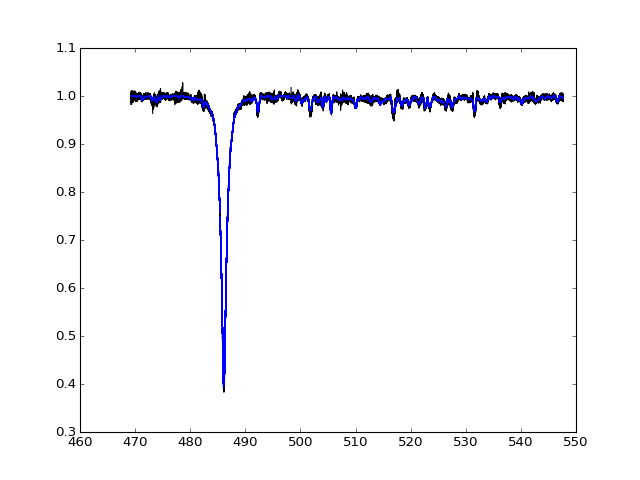

In [14]:
%matplotlib notebook
flat_fitter.plot()

In [15]:
flat_fitter.samples.describe()

,RV,epsilon,lnprob,vsini
count,4124.000000,4124.000000,4124.000000,4124.000000
mean,20.340693,0.761038,210525.174745,160.697064
std,0.077440,0.023371,1.234898,0.563445
min,20.045346,0.671194,210516.586499,158.404716
25%,20.289469,0.745627,210524.625913,160.320050
50%,20.339371,0.761233,210525.518922,160.691003
75%,20.392416,0.776154,210526.068712,161.065985
max,20.631905,0.845055,210526.655441,162.725826


# Does the emcee backend work?

In [ ]:
emcee_fitter = Fitters.RVFitter(flattened_orders, model_library=hdf5_filename, 
                               T=fitter._T, logg=fitter._logg, feh=fitter._feh)
emcee_fitter.fit(backend='emcee', n_burn=100, n_prod=300, guess=False, initial_pars=[20.34, 160.70, 0.761])

Determine Chunk Log: Wl is 65536
Running burn-in

INFO:root:Done with burn-in iteration 1 / 100
INFO:root:Done with burn-in iteration 11 / 100
INFO:root:Done with burn-in iteration 21 / 100
INFO:root:Done with burn-in iteration 31 / 100
INFO:root:Done with burn-in iteration 41 / 100
INFO:root:Done with burn-in iteration 51 / 100
INFO:root:Done with burn-in iteration 61 / 100
INFO:root:Done with burn-in iteration 71 / 100
INFO:root:Done with burn-in iteration 81 / 100


In [ ]:
emcee_fitter.triangle()

In [ ]:
emcee_fitter.plot()